In [1]:
# 核心库
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from chromasky_toolkit import config

print("✅ 环境设置完毕。")

✅ Config: 数据目录为 C:\Users\zhang\Documents\Code\chromasky-toolkit\map_data
✅ 环境设置完毕。


In [2]:
def analyze_nc_file(file_path: Path):
    """
    分析指定的 NetCDF 文件，并打印出可供分离的参数。
    """
    if not file_path.exists():
        print(f"❌ 文件不存在: {file_path}")
        return

    print(f"--- 正在分析文件: {file_path.name} ---")
    with xr.open_dataset(file_path, engine="netcdf4") as ds:
        # 1. 提取可用的 UTC 日期
        # 假设时间坐标名为 'valid_time' 或 'time'
        time_coord_name = 'valid_time' if 'valid_time' in ds.coords else 'time'
        if time_coord_name in ds.coords:
            unique_dates = pd.to_datetime(ds[time_coord_name].values).strftime('%Y-%m-%d').unique().tolist()
            print("\n【可用的 UTC 日期】:")
            for d in unique_dates:
                print(f"- {d}")

            # 2. 提取可用的 UTC 时间
            unique_times = pd.to_datetime(ds[time_coord_name].values).strftime('%H:%M').unique().tolist()
            print("\n【可用的 UTC 时间 (小时:分钟)】:")
            # 每行打印 6 个，方便查看
            for i in range(0, len(unique_times), 6):
                print("- " + "  ".join(unique_times[i:i+6]))
        else:
            print("未找到有效的时间坐标 ('valid_time' 或 'time')。")

        # 3. 提取可用的图层 (数据变量)
        print("\n【可用的图层 (变量)】:")
        for var_name in ds.data_vars:
            print(f"- {var_name:<10} ({ds[var_name].attrs.get('long_name', 'N/A')})")

# --- 执行分析 ---
TARGET_DATE_STR = "2025-07-04"
target_date_obj = pd.to_datetime(TARGET_DATE_STR).date()
raw_data_path = config.ERA5_DATA_DIR / target_date_obj.strftime('%Y-%m-%d') / "era5_data.nc"

analyze_nc_file(raw_data_path)

--- 正在分析文件: era5_data.nc ---

【可用的 UTC 日期】:
- 2025-07-03
- 2025-07-04

【可用的 UTC 时间 (小时:分钟)】:
- 00:00  10:00  11:00  12:00  13:00  20:00
- 21:00  22:00  23:00

【可用的图层 (变量)】:
- hcc        (High cloud cover)
- mcc        (Medium cloud cover)
- lcc        (Low cloud cover)
- tcc        (Total cloud cover)
- sp         (Surface pressure)
- t2m        (2 metre temperature)
- d2m        (2 metre dewpoint temperature)


In [3]:
def extract_and_save_slice(source_nc_path: Path, utc_date: str, utc_time: str, variable: str) -> Path | None:
    """
    从大的 NetCDF 文件中提取一个数据切片并保存。
    """
    if not source_nc_path.exists():
        print(f"❌ 源文件不存在: {source_nc_path}")
        return None

    with xr.open_dataset(source_nc_path, engine="netcdf4") as ds:
        try:
            # 构建目标时间点
            target_datetime = f"{utc_date}T{utc_time}"
            
            # 使用 .sel() 选择最接近该时间点的数据
            time_coord_name = 'valid_time' if 'valid_time' in ds.coords else 'time'
            data_slice = ds[variable].sel({time_coord_name: target_datetime}, method='nearest')
            
            # 构建分组的输出路径
            time_str_for_path = utc_time.replace(':', '')
            output_dir = config.PROCESSED_DATA_DIR / utc_date
            output_dir.mkdir(parents=True, exist_ok=True)
            output_path = output_dir / f"{variable}_{time_str_for_path}.nc"
            
            # 保存为新的 NetCDF 文件
            data_slice.to_netcdf(output_path)
            print(f"✅ 数据切片已成功保存到: {output_path}")
            return output_path
            
        except KeyError:
            print(f"❌ 错误: 变量 '{variable}' 或时间坐标 '{time_coord_name}' 在数据集中不存在。")
        except Exception as e:
            print(f"❌ 提取或保存时发生错误: {e}")
        
    return None

# --- 执行分离 ---
# 根据上一步的分析结果，手动选择你想要分离的参数
target_utc_date = "2025-07-04"
target_utc_time = "21:00"  # 例如选择 UTC 12:00 (对应北京时间晚上8点)
target_variable = "hcc"    # 例如选择高云量 (High cloud cover)

# 确保原始数据文件存在
if raw_data_path.exists():
    saved_slice_path = extract_and_save_slice(raw_data_path, target_utc_date, target_utc_time, target_variable)
else:
    print(f"原始数据文件 {raw_data_path} 不存在，无法执行分离。")
    saved_slice_path = None

✅ 数据切片已成功保存到: C:\Users\zhang\Documents\Code\chromasky-toolkit\data\processed\2025-07-04\hcc_2100.nc


2025-08-06 19:00:44,618 - MapDrawer - INFO - --- [绘图] 开始生成地图: High cloud cover on 2025-07-04 at 21:00 UTC ---
2025-08-06 19:00:46,997 - MapDrawer - INFO - --- [绘图] 地图已成功保存到: C:\Users\zhang\Documents\Code\chromasky-toolkit\data\processed\2025-07-04\hcc_2100.png ---


✅ 地图生成成功！正在 Notebook 中显示...


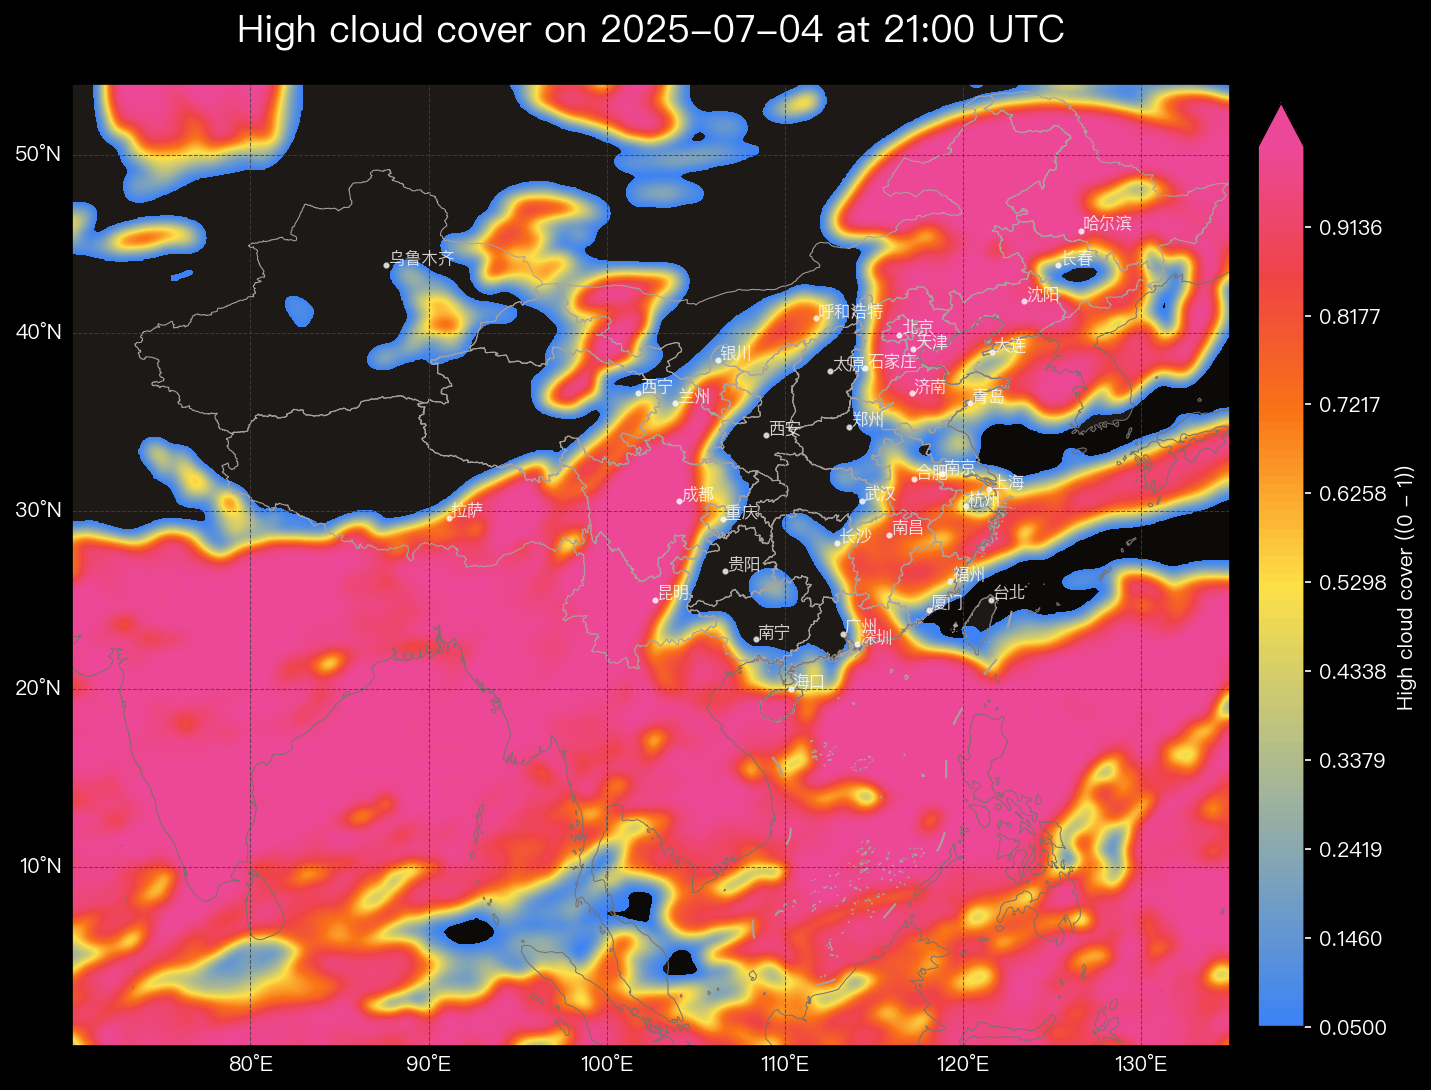

In [5]:
# --- 导入我们重构好的绘图函数 ---
from chromasky_toolkit.map_drawer import generate_map_from_grid
from IPython.display import display, Image # 确保 Image 已导入

# --- 执行可视化 ---
if 'saved_slice_path' in locals() and saved_slice_path and saved_slice_path.exists():
    # 加载分离出来的数据
    data_slice = xr.open_dataarray(saved_slice_path)
    
    # 创建一个描述性的标题
    map_title = f"{data_slice.attrs.get('long_name', data_slice.name)} on {target_utc_date} at {target_utc_time} UTC"
    
    # 定义地图图片的输出路径 (可选，如果不想保存，可以设为 None)
    map_output_path = saved_slice_path.with_suffix('.png')
    
    # --- 新的调用方式 ---
    # 调用绘图函数，它会返回图像的二进制数据
    image_bytes = generate_map_from_grid(data_slice, map_title, map_output_path)
    
    # 检查是否成功返回了图像数据
    if image_bytes:
        print("✅ 地图生成成功！正在 Notebook 中显示...")
        # 直接使用返回的二进制数据显示图像，无需从文件读取
        display(Image(data=image_bytes, width=1920))
    else:
        print("❌ 地图生成失败。")
else:
    print("⚠️ 未找到已分离的数据文件，无法进行可视化。")